In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
meas_sel = [Measurement.id,
            Measurement.station,
            Measurement.date,
            Measurement.prcp,
            Measurement.tobs]
station_sel = [Station.id,
               Station.station,
               Station.name,
               Station.latitude,
               Station.longitude,
               Station.elevation]

In [13]:
session.query(*station_sel).all()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [14]:
session.query(*meas_sel).all()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0),
 (16, 'USC00519397', '2010-01-18', 0.0, 72.0),
 (17, 'USC00519397', '2010-01-19', 0.0, 66.0),
 (18, 'USC00519397', '2010-01-20', 0.0, 66.0),
 (19, 'USC00519397', '2010-01-21', 0.0, 69.0),
 (20, 'USC00519397', '2010-01-22', 0.0, 67.0),
 (21, 'USC00519397', '2010-01-23', 0.0, 67.0),
 (22, 'USC00519397

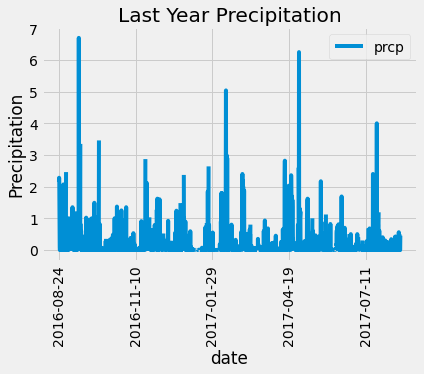

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

last_date_str = (session.query(func.max(Measurement.date)).all())[0][0]
last_date =  dt.datetime.strptime(last_date_str, '%Y-%m-%d')
start_date = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df_prcp = pd.read_sql(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date).statement, engine)

# Sort the dataframe by date
df_prcp = df_prcp.sort_values('date')
df_prcp = df_prcp.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data

df_prcp.plot()
plt.title("Last Year Precipitation")
plt.ylabel('Precipitation')
plt.xticks(rotation=90)
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
results = session.query(Measurement.station).group_by(Measurement.station).all()

print(f'There around {len(results)} stations available in this dataset')

There around 9 stations available in this dataset


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station,
              func.count(Measurement.station)
            ).group_by(Measurement.station
            ).order_by(func.count(Measurement.station).desc()
            ).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Extract station id of most used station
Most_used_station = results[0][0]

Most_used_station

'USC00519281'

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

Min_temp = session.query(Measurement.station,
                        func.min(Measurement.tobs)
            ).filter(Measurement.station == Most_used_station
            ).all()

Max_temp = session.query(Measurement.station,
                        func.max(Measurement.tobs)
            ).filter(Measurement.station == Most_used_station
            ).all()

Avg_temp = session.query(Measurement.station,
                        func.avg(Measurement.tobs)
            ).filter(Measurement.station == Most_used_station
            ).all()

print(f"The minimum temperature from station {Min_temp[0][0]} is {Min_temp[0][1]}")
print(f"The maximum temperature from station {Max_temp[0][0]} is {Max_temp[0][1]}")
print(f"The average temperature from station {Avg_temp[0][0]} is {round(Avg_temp[0][1],1)}")

The minimum temperature from station USC00519281 is 54.0
The maximum temperature from station USC00519281 is 85.0
The average temperature from station USC00519281 is 71.7


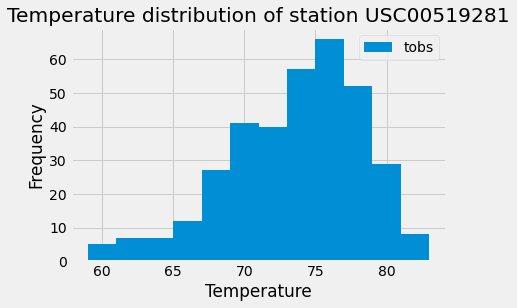

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

df_temp_m = pd.read_sql(session.query(Measurement.station,
                        Measurement.tobs
            ).filter((Measurement.date >= start_date
            ) & (Measurement.station == Most_used_station
            )).statement, engine)

df_temp_m.plot.hist(bins=12)
plt.title(f'Temperature distribution of station {Most_used_station}')
plt.xlabel('Temperature')
plt.show()

## Bonus Challenge Assignment

In [22]:
def gendata(population1, population2):
#     population1 = stats.norm.rvs(loc=loc1, size=50, random_state=0)
#     population2 = stats.norm.rvs(loc=loc2, size=45, random_state=42)

    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(population1)), population1, label="population1")
    plt.scatter(range(len(population2)), population2, label="population2")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(population1, 15, density=True, alpha=0.7, label="population1")
    plt.hist(population2, 15, density=True, alpha=0.7, label="population2")
    plt.axvline(population1.mean()[0], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(population2.mean()[0], color='k', linestyle='dashed', linewidth=1)
    plt.legend()  
    plt.show()
    
#     return population1, population2

The average temperature in June is 74.94
The average temperature in June is 71.04


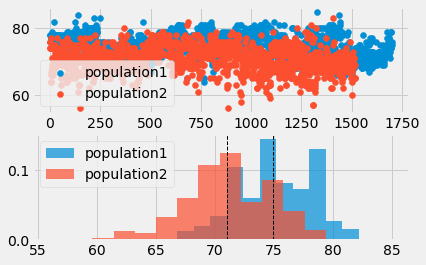

In [23]:
# Find and store June & Dec temperature through all years as separate Dataframe
df_June_temp = pd.read_sql(session.query(Measurement.tobs#,Measurement.date
             ).filter(extract('month', Measurement.date)==6
             ).statement, engine)
df_Dec_temp = pd.read_sql(session.query(Measurement.tobs#,Measurement.date
             ).filter(extract('month', Measurement.date)==12
             ).statement, engine)
print(f"The average temperature in June is {round(df_June_temp.mean()[0],2)}")
print(f"The average temperature in June is {round(df_Dec_temp.mean()[0],2)}")
gendata(df_June_temp,df_Dec_temp)


In [24]:
print("Unpaired results")
print(stats.ttest_ind(df_June_temp, df_Dec_temp, equal_var=False))
print("")
print("Unpaired t-test is used in this instance because although they are both measuring temperature, but they are 2 differnt populations from 2 different seansons.")

Unpaired results
Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

Unpaired t-test is used in this instance because although they are both measuring temperature, but they are 2 differnt populations from 2 different seansons.


In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    last_date =  dt.datetime.strptime(last_date_str, '%Y-%m-%d')
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Input vacation start and end date
vacation_start_date_str = "2022-06-01"
vacation_end_date_str = "2022-06-09"

# Change vacation start and end date to datetime format
vacation_start_date = dt.datetime.strptime(vacation_start_date_str, '%Y-%m-%d')
vacation_end_date = dt.datetime.strptime(vacation_end_date_str, '%Y-%m-%d')

# Find equivalent end date that is within the previous year data
ref_end_date = vacation_end_date
while ((ref_end_date - last_date).days)>0:
    ref_end_date = ref_end_date - dt.timedelta(days=365) 
    
    # Code to Minus one extra day for leap year
    year_check=ref_end_date.year/4
    if year_check-int(year_check)==0:
        ref_end_date = ref_end_date - dt.timedelta(days=1)
    

# Find number of days of vacation
no_of_vacation_days = ((vacation_end_date- vacation_start_date).days)

# Obtain equivalent start date that is within previous year data
ref_start_date = ref_end_date - dt.timedelta(days = no_of_vacation_days)
ref_start_date_str = ref_start_date.strftime("%Y-%m-%d")
ref_end_date_str = ref_end_date.strftime("%Y-%m-%d")

results = calc_temps(ref_start_date, ref_end_date)

print("For vacation with the below dates")
print(f"Start date: {vacation_start_date_str} referencing data from: {ref_start_date_str}")
print(f"End date: {vacation_end_date_str} referencing data from: {ref_end_date_str}")
print(f"Min Temp: {results[0][0]}")
print(f"Avg Temp: {round(results[0][1],1)}")
print(f"Max Temp: {results[0][2]}")

For vacation with the below dates
Start date: 2022-06-01 referencing data from: 2017-06-01
End date: 2022-06-09 referencing data from: 2017-06-09
Min Temp: 72.0
Avg Temp: 77.8
Max Temp: 81.0


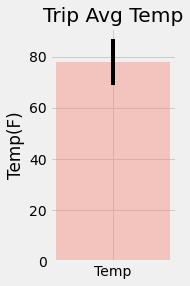

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,4))
plt.bar('Temp',round(results[0][1],1),yerr =(results[0][2]-results[0][0]),color='salmon', alpha=0.4)
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")

plt.show()


In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

df = pd.read_sql(session.query(func.avg(Measurement.prcp).label("Average precipitation"),
              Station.station,
              Station.name,
              Station.latitude,
              Station.longitude,
              Station.elevation
             ).filter(Station.station == Measurement.station
             ).filter(Measurement.date >= ref_start_date
             ).filter(Measurement.date <= ref_end_date
             ).group_by(Station.station
             ).order_by(func.avg(Measurement.prcp).desc()
             ).statement, engine)

df

,Average precipitation,station,name,latitude,longitude,elevation
0,0.16800,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,0.06125,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,0.04875,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,0.04625,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
4,0.01875,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,0.00250,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,NaN,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("06-01")

[(64.0, 74.6140350877193, 81.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip
start = vacation_start_date
end = vacation_end_date
date_list = []
# Use the start and end date to create a range of dates
while start<= end:
    date_list.append(start.strftime("%m-%d"))
    start = start + dt.timedelta(days =1)

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in date_list:
    normals.append(daily_normals(date)[0])
normals

[(64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0)]

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_tobs_vac = pd.DataFrame(normals)
df_tobs_vac['date'] = date_list
df_tobs_vac = df_tobs_vac.set_index('date')
df_tobs_vac = df_tobs_vac.rename(columns = {0:'Min temp', 1:'Average temp',2:'Max temp'})
df_tobs_vac

,Min temp,Average temp,Max temp
date,,,
06-01,64.0,74.614035,81.0
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0


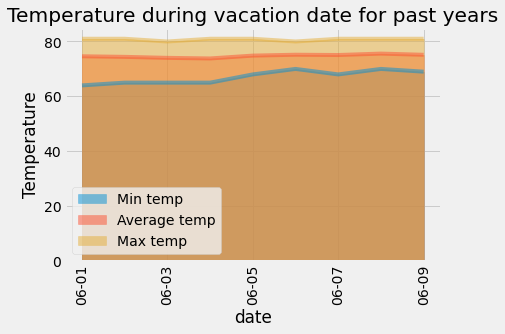

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
df_tobs_vac.plot.area(stacked=False)
plt.title('Temperature during vacation date for past years')
plt.ylabel('Temperature')
plt.xlabel('date')
plt.xticks(rotation=90)
plt.show()